In [2]:
# !pip install tensorflow_datasets==4.3

     |████████████████████████████████| 3.9 MB 5.2 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from cv2 import cv2
from skimage import feature
# from google.colab.patches import cv2_imshow

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'deep_weeds',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


In [3]:
get_label_name = metadata.features['label'].int2str
def visualize(image, label):
  _ = plt.imshow(image)
  _ = plt.title(get_label_name(label))

# helpers
def compare(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [4]:
train_ds_numpy = [(example.numpy(), label.numpy()) for example, label in train_ds if label < 8]
test_ds_numpy = [(example.numpy(), label.numpy()) for example, label in test_ds if label < 8]

x_train = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

x_test = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

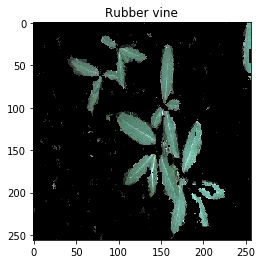

In [5]:
image, label = (x_test[5], y_test[5])
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

## mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))

imask = mask>0
green = np.zeros_like(image, np.uint8)
green[imask] = image[imask]

visualize(green, label)

In [6]:
x_train_hsv = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2HSV), x_train))
x_test_hsv = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2HSV), x_test))

x_train_mask = list(map(lambda hsv: cv2.inRange(hsv, (36, 25, 25), (70, 255,255)), x_train_hsv))
x_test_mask = list(map(lambda hsv: cv2.inRange(hsv, (36, 25, 25), (70, 255,255)), x_test_hsv))

x_train_imask = list(map(lambda mask: mask > 0, x_train_mask))
x_test_imask = list(map(lambda mask: mask > 0, x_test_mask))

In [7]:
train_green = list(map(lambda image: np.zeros_like(image, np.uint8), x_train))
test_green = list(map(lambda image: np.zeros_like(image, np.uint8), x_test))

In [8]:
print(len(train_green))
x_train_green = []
for i in range(0, len(train_green)):
  green = train_green[i]
  imask = x_train_imask[i]
  image = x_train[i]
  green[imask] = image[imask]
  x_train_green.append(green)

6672


In [9]:
print(len(test_green))
x_test_green = []
for j in range(0, len(test_green)):
  green = test_green[j]
  imask = x_test_imask[j]
  image = x_test[j]
  green[imask] = image[imask]
  x_test_green.append(green)

863


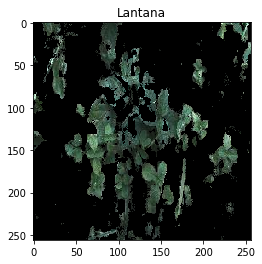

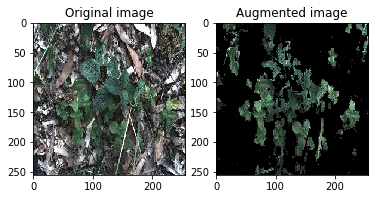

In [10]:
i = 0
visualize(x_train_green[i], y_train[i])
compare(x_train[i], x_train_green[i])

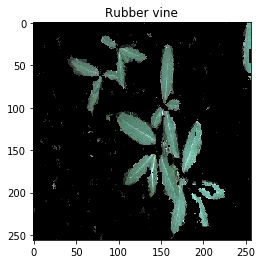

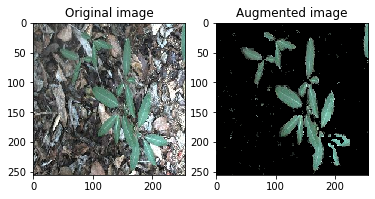

In [11]:
i = 5
visualize(x_test_green[i], y_test[i])
compare(x_test[i], x_test_green[i])


In [12]:
print(np.array(x_train_green[9]).shape)
# print(x_train_green[9])

(256, 256, 3)


In [13]:
x_train_gray = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), x_train_green))
x_test_gray = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), x_test_green))

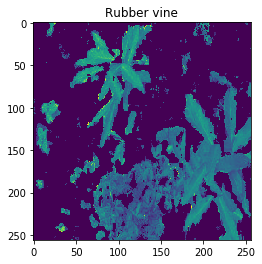

In [14]:
i = 5
visualize(x_train_gray[i], y_train[i])

In [15]:
gray = x_train_gray[0]
gray_label = y_train[0]

In [16]:
# parameters
CANNY_THRESH_1 = 10
CANNY_THRESH_2 = 200

In [17]:
# edge detection
edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)

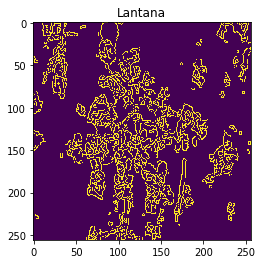

In [18]:
visualize(edges, gray_label)

In [19]:
x_train_canny = list(map(lambda x: cv2.Canny(x, CANNY_THRESH_1, CANNY_THRESH_2), x_train_gray))
x_test_canny = list(map(lambda x: cv2.Canny(x, CANNY_THRESH_1, CANNY_THRESH_2), x_test_gray))


Text(0.5, 1.0, 'from x_test_gray')

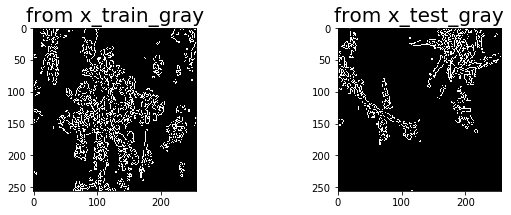

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

ax[0].imshow(x_train_canny[0], cmap='gray')
ax[0].set_title(r'from x_train_gray', fontsize=20)

ax[1].imshow(x_test_canny[0], cmap='gray')
ax[1].set_title(r'from x_test_gray', fontsize=20)

In [21]:
x_train_canny_flattened = list(map(lambda x: x.flatten(), x_train_canny))
x_test_canny_flattened = list(map(lambda x: x.flatten(), x_test_canny))

In [22]:
print(np.array(x_train_canny_flattened).shape)

(6672, 65536)


In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(x_train_canny_flattened, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [45]:
from sklearn import neighbors
n_neighbors = 20
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(clf.transform(x_train_canny_flattened), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [46]:
x_train_transformed = clf.transform(x_train_canny_flattened)
print(x_train_transformed[0])

x_test_transformed = clf.transform(x_test_canny_flattened)
print(x_test_transformed[0])

[-2.81790922 -0.33401646 -1.30120253  3.79955077 -6.90172969 -3.7752325
 -0.79694599]
[ 3.30214445  3.65752668 10.09982345  6.51059956  0.48164539 -0.95748447
  1.78547355]


In [47]:
print(knn.predict([x_test_transformed[0]]))
print(y_test[0])

[1]
6


In [48]:
acc_knn = knn.score(x_test_transformed, y_test)
print(acc_knn)

0.12862108922363846
